In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [109]:
df = pd.read_csv('train.csv', parse_dates=['Date'])

# Ensuring date is sorted
df = df.sort_values('Date').reset_index(drop=True)

print('Rows, Columns:', df.shape)
print(df.dtypes)
df.head(10)

Rows, Columns: (230090, 4)
Date           datetime64[ns]
store                   int64
product                 int64
number_sold             int64
dtype: object


,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-01,6,1,957
2,2010-01-01,4,9,947
3,2010-01-01,3,6,378
4,2010-01-01,1,1,745
5,2010-01-01,5,0,861
6,2010-01-01,6,5,907
7,2010-01-01,3,5,369
8,2010-01-01,5,7,880
9,2010-01-01,0,4,938


In [111]:
#not checking for null values as it is already mentioned in description that there is no null values

In [113]:
# checking that any duplicates value present
print('\nDuplicate rows:', df.duplicated().sum())


# basic statistics for numer_sold
display(df['number_sold'].describe())

# Value counts for stores and products
print('\nUnique stores:', df['store'].nunique())
print('Unique products:', df['product'].nunique())
print('\nObservations per store:')
print(df['store'].value_counts().sort_index())
print('\nObservations per product:')
print(df['product'].value_counts().sort_index())


Duplicate rows: 0


count    230090.000000
mean        780.926107
std         204.096737
min         238.000000
25%         722.000000
50%         835.000000
75%         914.000000
max        1205.000000
Name: number_sold, dtype: float64


Unique stores: 7
Unique products: 10

Observations per store:
store
0    32870
1    32870
2    32870
3    32870
4    32870
5    32870
6    32870
Name: count, dtype: int64

Observations per product:
product
0    23009
1    23009
2    23009
3    23009
4    23009
5    23009
6    23009
7    23009
8    23009
9    23009
Name: count, dtype: int64


In [115]:
# No duplicates are there , total 7 unique stores with 10 unique products 
# Basic statistics of number_sold is shown

In [119]:
# We'll create daily, monthly and yearly aggregated series to study trends.

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

daily = df.groupby('Date')['number_sold'].sum().rename('sales_daily')
monthly = df.set_index('Date').resample('ME')['number_sold'].sum().rename('sales_monthly')
yearly = df.set_index('Date').resample('YE')['number_sold'].sum().rename('sales_yearly')

# Derived daily, monthly and yearly aggregated series are computed by summing
# number_sold across all stores and products. Aggregated series smooth noise
# and reveal trends or seasonality at different granularities.


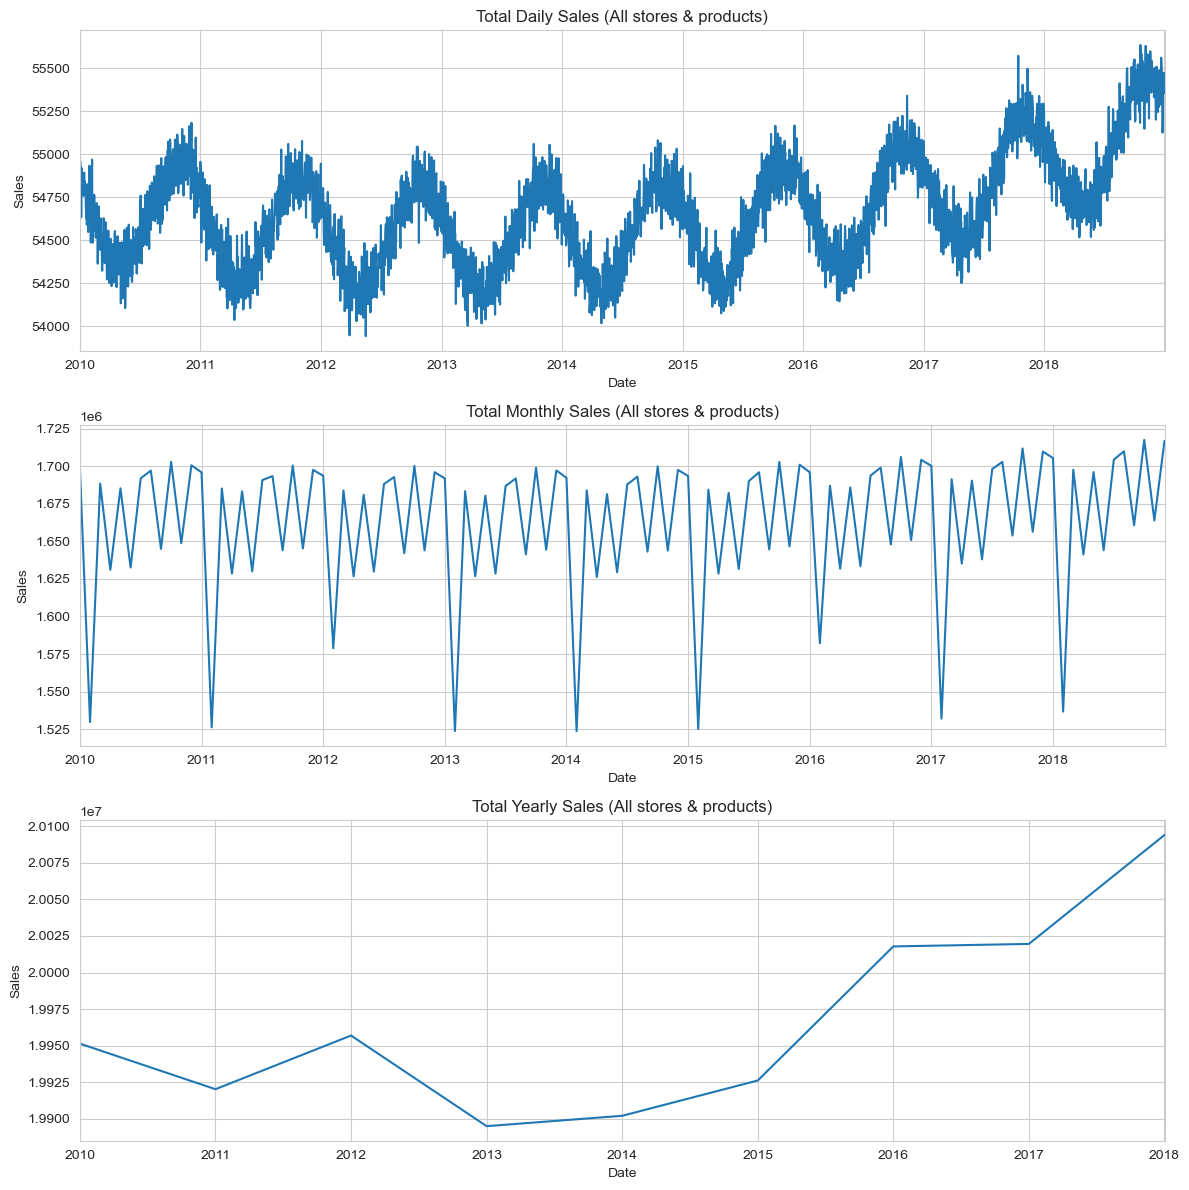

In [123]:

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)

daily.plot(ax=axes[0], title='Total Daily Sales (All stores & products)')
axes[0].set_ylabel('Sales')

monthly.plot(ax=axes[1], title='Total Monthly Sales (All stores & products)')
axes[1].set_ylabel('Sales')

yearly.plot(ax=axes[2], title='Total Yearly Sales (All stores & products)')
axes[2].set_ylabel('Sales')

plt.tight_layout()
plt.show()


In [125]:
# DAILY GRAPH : Each year contains several recurring peaks and troughs, suggesting periodic demand fluctuations 
#possibly linked to monthly cycles, promotions, or holidays.

# MONTHLY GRAPH : Despite regular cycles, the amplitude (difference between peak and trough) remains consistent, meaning no significant
#increase in seasonality intensity over time.

# YEARLY GRAPH : Sales remained relatively stable from 2010 to 2014, followed by a noticeable increase post-2015, 
# highest total sales in 2018.

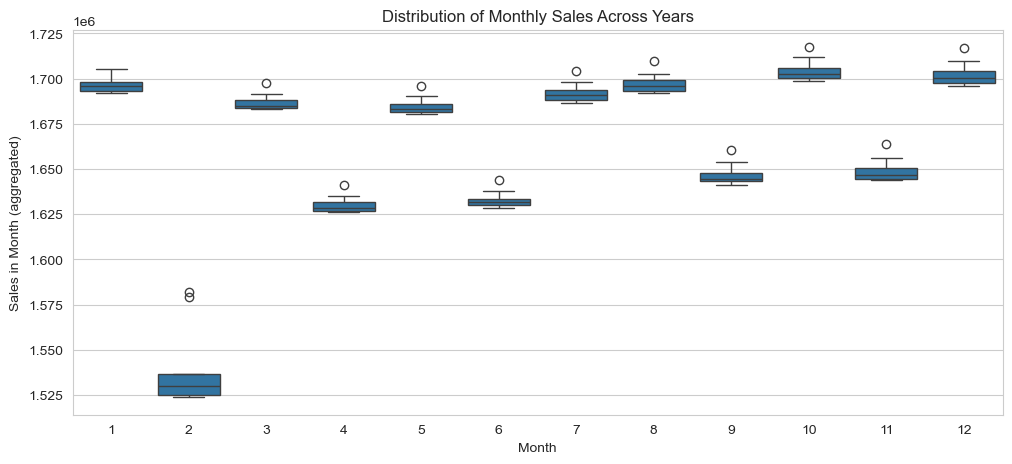

In [129]:
# Seasonality: monthly boxplot and heatmap (month vs year)
# Boxplot of sales by month (aggregated across years)
monthly_by_month = df.copy()
monthly_by_month['month'] = monthly_by_month['Date'].dt.month
monthly_agg = monthly_by_month.groupby(['year', 'month'])['number_sold'].sum().reset_index()

plt.figure(figsize=(12,5))
sns.boxplot(x='month', y='number_sold', data=monthly_agg)
plt.title('Distribution of Monthly Sales Across Years')
plt.xlabel('Month')
plt.ylabel('Sales in Month (aggregated)')
plt.show()

In [ ]:
#Sales show a clear seasonal trend — months like Jan, Aug, Oct, Nov, and Dec have higher sales, while Feb and June are lower.
#The sales pattern is consistent across years with only a few outliers, showing that monthly demand is stable and predictable.


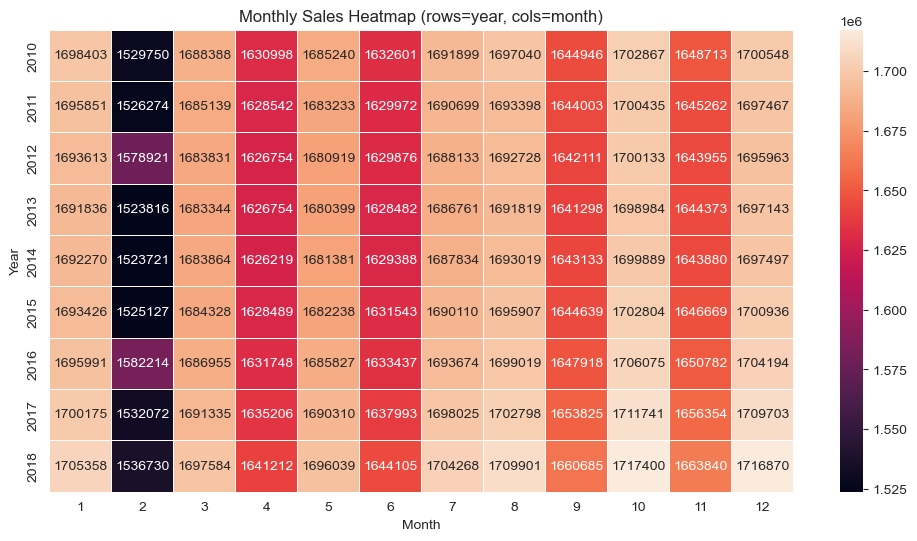

In [131]:
# Heatmap: pivot table year vs month
pivot = monthly_agg.pivot(index='year', columns='month', values='number_sold')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt='.0f', linewidths=.5)
plt.title('Monthly Sales Heatmap (rows=year, cols=month)')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()

In [ ]:
#The heatmap shows that sales remain strong and consistent across all years, with slightly higher sales in October–December and 
#lower sales in February–April.
#This confirms a repeating seasonal pattern every year, indicating stable yearly performance with predictable monthly fluctuations.


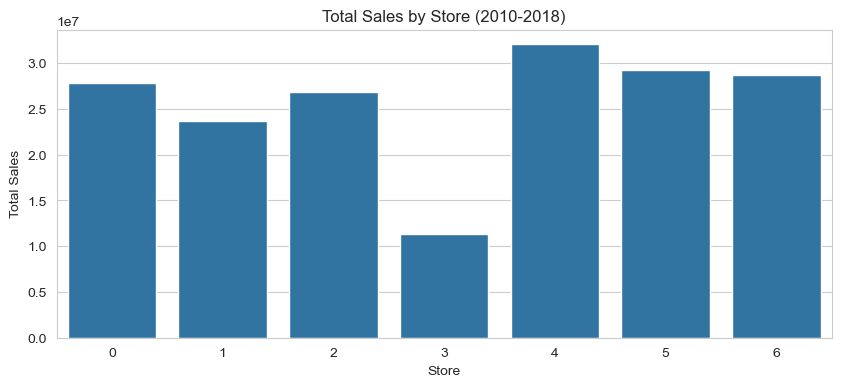

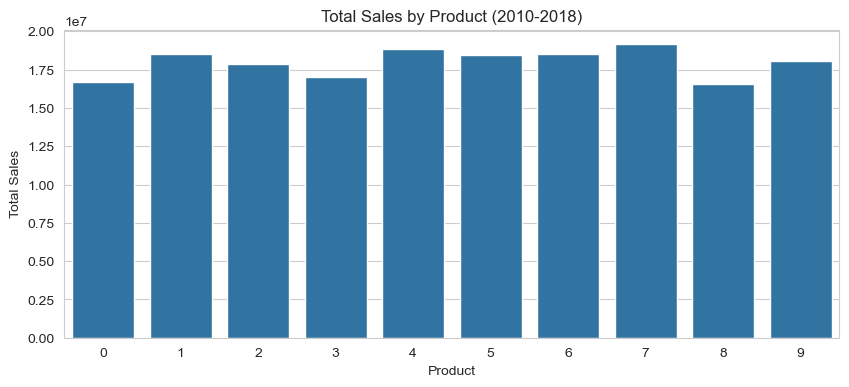

In [135]:
#Store-level & Product-level trends
# Top-level: total sales per store and per product across the whole period
store_totals = df.groupby('store')['number_sold'].sum().sort_values(ascending=False)
product_totals = df.groupby('product')['number_sold'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x=store_totals.index, y=store_totals.values)
plt.title('Total Sales by Store (2010-2018)')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=product_totals.index, y=product_totals.values)
plt.title('Total Sales by Product (2010-2018)')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.show()

In [139]:
#From above two bar graphs it is clearly seen that 4Th store sale is heighest and 3rd store is least.
# Product 7 is top selling product while product 8 is least

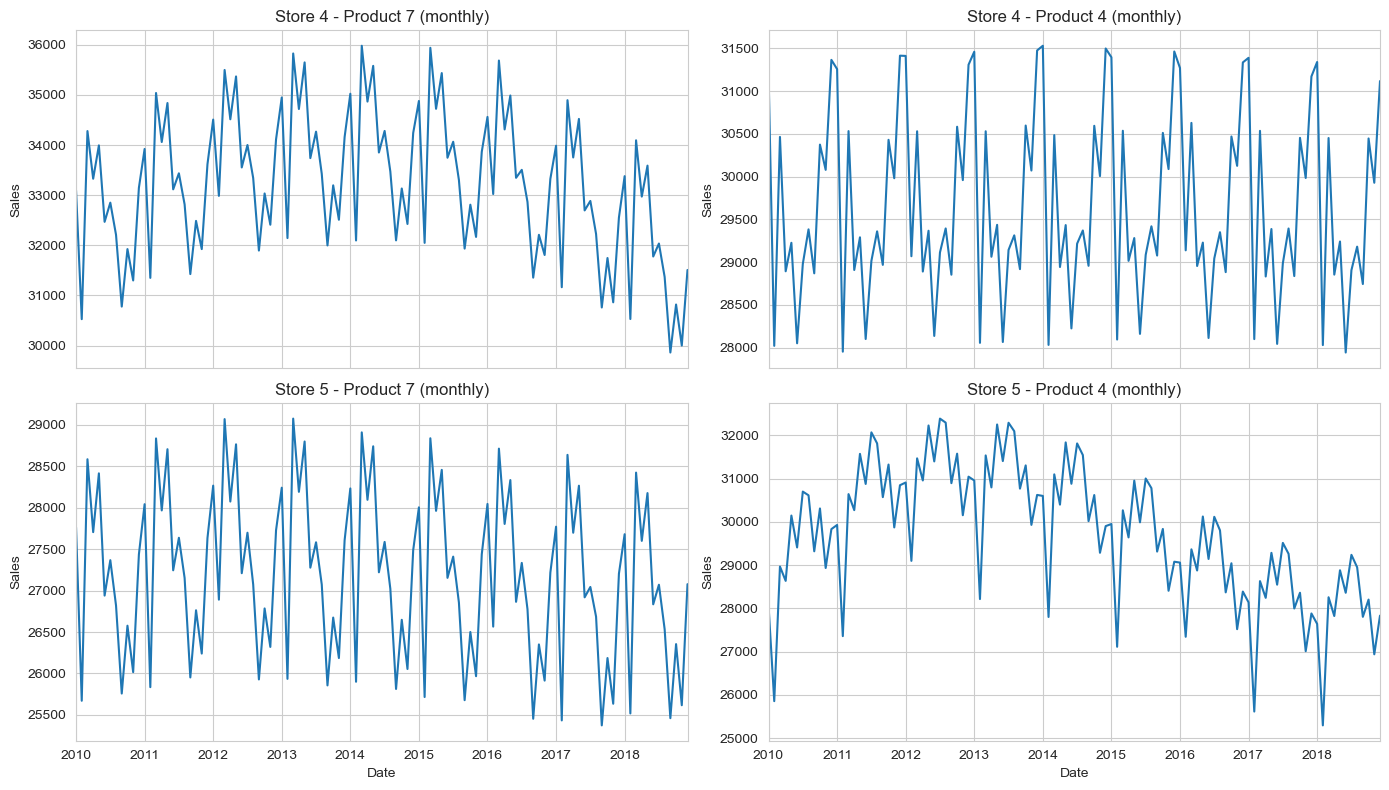

In [143]:
# Time series examples: I am choosing only few store-product combinations
# and plot their monthly series to inspect local patterns.

# Identifying top 2 products and top 2 stores (by total sales)
top_stores = store_totals.index[:2].tolist()
top_products = product_totals.index[:2].tolist()

# Plot monthly time series for each combination
fig, axes = plt.subplots(2, 2, figsize=(14,8), sharex=True)
for i, store in enumerate(top_stores):
    for j, product in enumerate(top_products):
        ax = axes[i, j]
        mask = (df['store'] == store) & (df['product'] == product)
        ser = df[mask].set_index('Date').resample('ME')['number_sold'].sum()
        ser.plot(ax=ax)
        ax.set_title(f'Store {store} - Product {product} (monthly)')
        ax.set_ylabel('Sales')

plt.tight_layout()
plt.show()

In [145]:
# as many combinations are posible , but i choose two 2 .
# by examining individual store-product monthly series helps identify localized seasonality or anomalies.

#Store 4 – Product 7 and Store 5 – Product 4 show a slight decline in sales after 2015.
#Store 4 – Product 4 and Store 5 – Product 7 have stable but repeating peaks, suggesting steady demand.

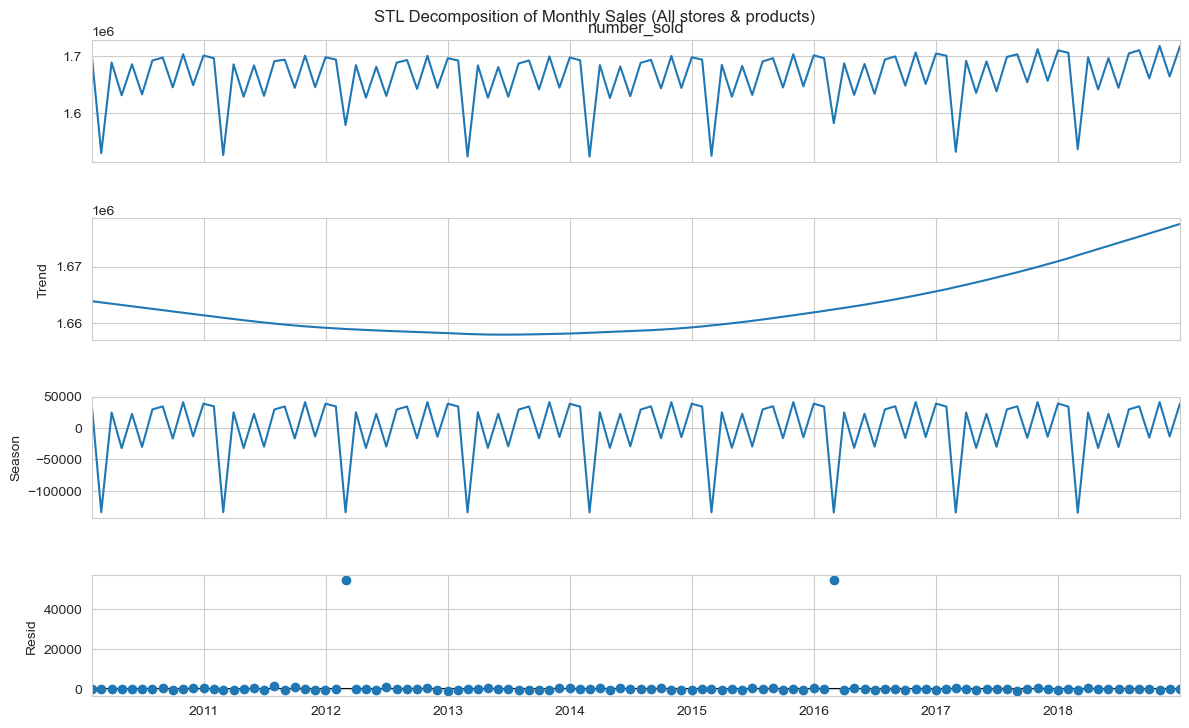

In [149]:
# For using STL and understanding it better I take help of web-search as I am not that knowledgeable to study it.
# Link of reference : https://doc.arcgis.com/en/insights/latest/analyze/stl.htm

# Decomposition STL - Seasonal and Trend decomposition using Loess on an aggregated series
# Doing STL on monthly series to extract trend/seasonal/residual
monthly_series = df.set_index('Date').resample('ME')['number_sold'].sum()
stl = STL(monthly_series, period=12, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
plt.suptitle('STL Decomposition of Monthly Sales (All stores & products)', y=0.95)
plt.show()

In [151]:
#STL decomposition separates the series into trend, seasonal, and remainder
# components. Trend shows the long-term movement; seasonal shows repeating
# patterns (annual here). Residuals indicate irregular fluctuations.


# The trend shows a small dip until around 2014, followed by a steady rise in sales after that.
#The seasonal pattern repeats every year, showing strong and regular ups and downs in sales.
# The residual plot highlights a few anomalies (e.g - spikes around 2012 and 2016), meaning some months had unexpected sales changes.


<Figure size 1200x400 with 0 Axes>

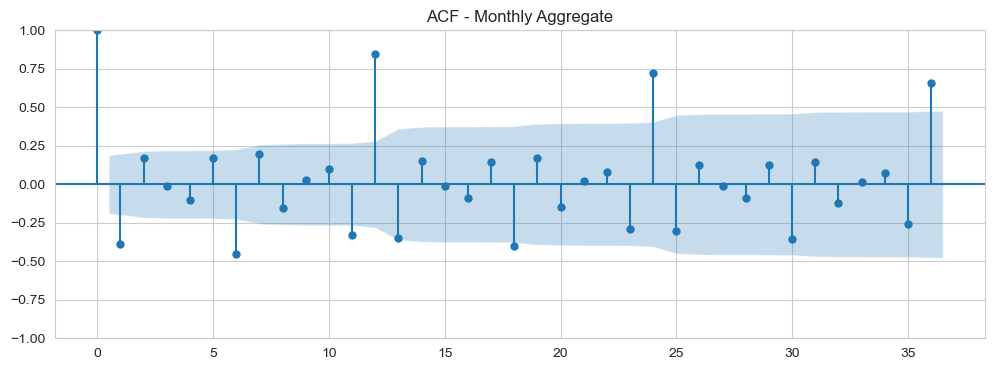

<Figure size 1200x400 with 0 Axes>

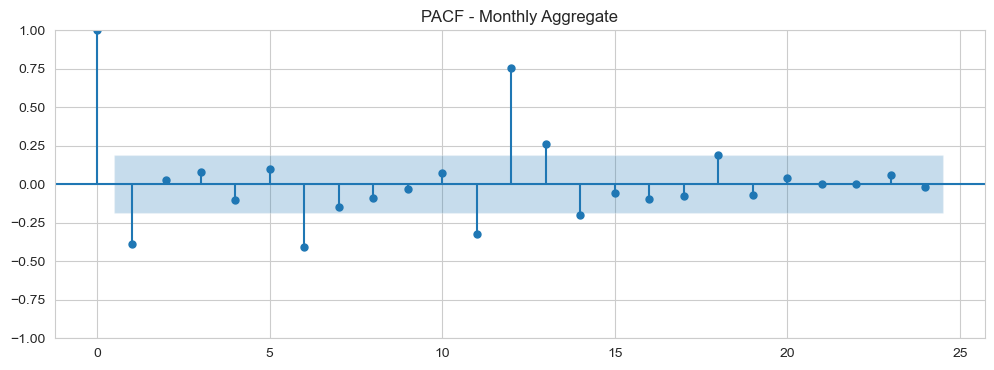

ADF Statistic: 0.5343272139492767
p-value: 0.9858799331312139
Critical Value (1%): -3.500
Critical Value (5%): -2.892
Critical Value (10%): -2.583


In [153]:
#Autocorrelation and stationarity
plt.figure(figsize=(12,4))
plot_acf(monthly_series.dropna(), lags=36)
plt.title('ACF - Monthly Aggregate')
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(monthly_series.dropna(), lags=24)
plt.title('PACF - Monthly Aggregate')
plt.show()

# Augmented Dickey-Fuller test for stationarity
adf_res = adfuller(monthly_series.dropna())
print('ADF Statistic:', adf_res[0])
print('p-value:', adf_res[1])
for k, v in adf_res[4].items():
    print('Critical Value (%s): %.3f' % (k, v))

In [155]:
# ACF/PACF plots help identify persistence and seasonality. The ADF test
# indicates whether the series is stationary — a small p-value (< 0.05)
# suggests stationarity. If non-stationary, consider differencing or detrending
# before modeling.

# The ACF plot shows strong spikes around lag 12, meaning sales have a yearly seasonal pattern.
# The PACF plot also shows clear spikes near lag 12, confirming annual seasonality.
# The ADF test p-value (0.98) is very high, which means the data is not stationary — trends or seasonality are still present.


In [161]:

# Anomaly Detection 
# While detecting anomalies , we have to be very carefull becuase there is thin line between Anomaly and Outlier
#All outliers are anomalies but vice-versa is not true 

monthly_series = df.set_index('Date').resample('ME')['number_sold'].sum()
monthly_df = monthly_series.reset_index().rename(columns={'number_sold':'sales'})
#I aggregate data monthly since it smooths short-term noise and highlights meaningful
# deviations at a business level. Monthly sales are ideal for detecting anomalies in temporal demand.


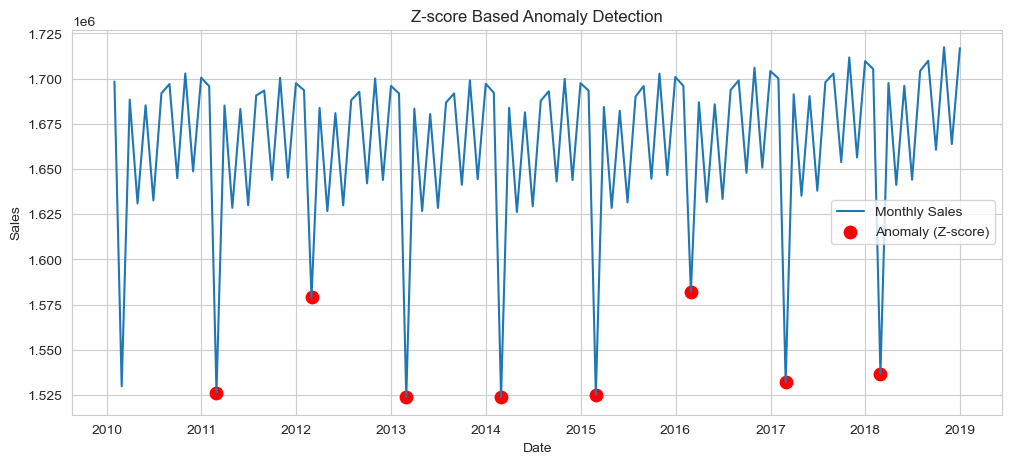

In [165]:
#METHOD - 1
#Statistical Anomaly Detection — Z-score based

window = 12
monthly_df['rolling_mean'] = monthly_df['sales'].rolling(window).mean()
monthly_df['rolling_std'] = monthly_df['sales'].rolling(window).std()

# Z-score relative to rolling mean
monthly_df['z_score'] = (monthly_df['sales'] - monthly_df['rolling_mean']) / monthly_df['rolling_std']

# Flag anomalies (Z > 2 or < -2)
monthly_df['anomaly_z'] = monthly_df['z_score'].abs() > 2

plt.figure(figsize=(12,5))
plt.plot(monthly_df['Date'], monthly_df['sales'], label='Monthly Sales')
plt.scatter(monthly_df.loc[monthly_df['anomaly_z'],'Date'],
monthly_df.loc[monthly_df['anomaly_z'],'sales'],
color='red', label='Anomaly (Z-score)', s=80, marker='o')
plt.title('Z-score Based Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Z-score anomaly detection highlights points that deviate significantly from their rolling 12-month context.
# Red dots mark unusually high or low sales compared to the trend-adjusted local distribution.

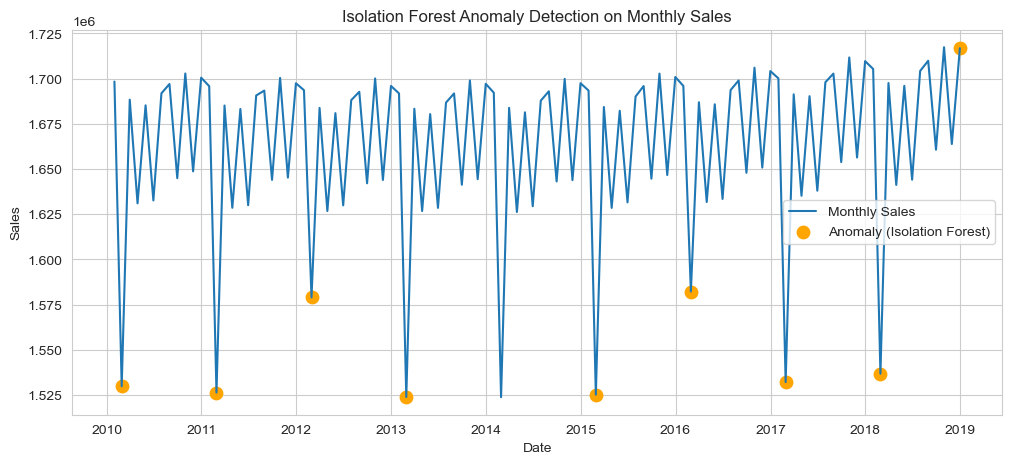

In [169]:

#Isolation Forest — ML-based anomaly detection
# Suitable for multivariate patterns (here we use time index + sales)

from sklearn.preprocessing import StandardScaler

# Feature prep
monthly_df['timestamp'] = (monthly_df['Date'] - monthly_df['Date'].min()).dt.days
X = monthly_df[['timestamp', 'sales']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit IsolationForest
iso = IsolationForest(contamination=0.08, random_state=42)
monthly_df['anomaly_iforest'] = iso.fit_predict(X_scaled)

# Label anomalies (-1 = anomaly)
monthly_df['anomaly_iforest'] = monthly_df['anomaly_iforest'] == -1

# Plot results
plt.figure(figsize=(12,5))
plt.plot(monthly_df['Date'], monthly_df['sales'], label='Monthly Sales')
plt.scatter(monthly_df.loc[monthly_df['anomaly_iforest'],'Date'],
monthly_df.loc[monthly_df['anomaly_iforest'],'sales'],
color='orange', s=80, label='Anomaly (Isolation Forest)')
plt.title('Isolation Forest Anomaly Detection on Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [171]:
# Isolation Forest is a machine learning algorithm designed to isolate anomalies based on data partitioning. It handles non-linear patterns 
#and multivariate features better than simple threshold-based rules.

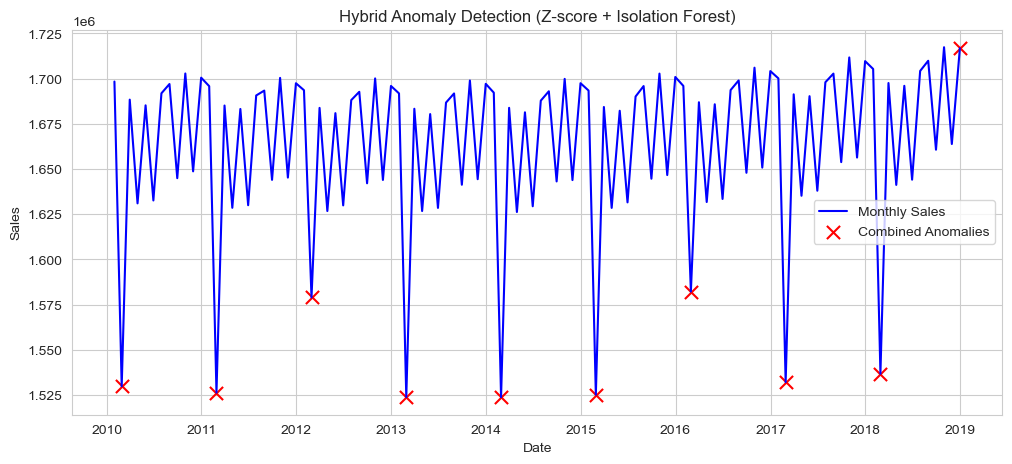

In [173]:
#Hybrid approach: combine Z-score and Isolation Forest anomalies
monthly_df['anomaly_combined'] = monthly_df['anomaly_z'] | monthly_df['anomaly_iforest']

plt.figure(figsize=(12,5))
plt.plot(monthly_df['Date'], monthly_df['sales'], label='Monthly Sales', color='blue')
plt.scatter(monthly_df.loc[monthly_df['anomaly_combined'],'Date'],
monthly_df.loc[monthly_df['anomaly_combined'],'sales'],
color='red', s=90, marker='x', label='Combined Anomalies')
plt.title('Hybrid Anomaly Detection (Z-score + Isolation Forest)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [175]:
# The hybrid visualization highlights consensus anomalies — points identified by both
# methods. This approach reduces false positives and ensures flagged points represent
# genuinely unusual sales events.

In [177]:
#Inspect detected anomalies and quantify impact
anomalies = monthly_df.loc[monthly_df['anomaly_combined'], ['Date','sales','z_score']]
print('Total anomalies detected:', len(anomalies))
display(anomalies.sort_values('Date'))

Total anomalies detected: 10


,Date,sales,z_score
1,2010-02-28,1529750,NaN
13,2011-02-28,1526274,-2.674610
25,2012-02-29,1578921,-2.228153
37,2013-02-28,1523816,-2.671620
49,2014-02-28,1523721,-2.667843
61,2015-02-28,1525127,-2.657443
73,2016-02-29,1582214,-2.184095
85,2017-02-28,1532072,-2.639454
97,2018-02-28,1536730,-2.636597
107,2018-12-31,1716870,0.824624


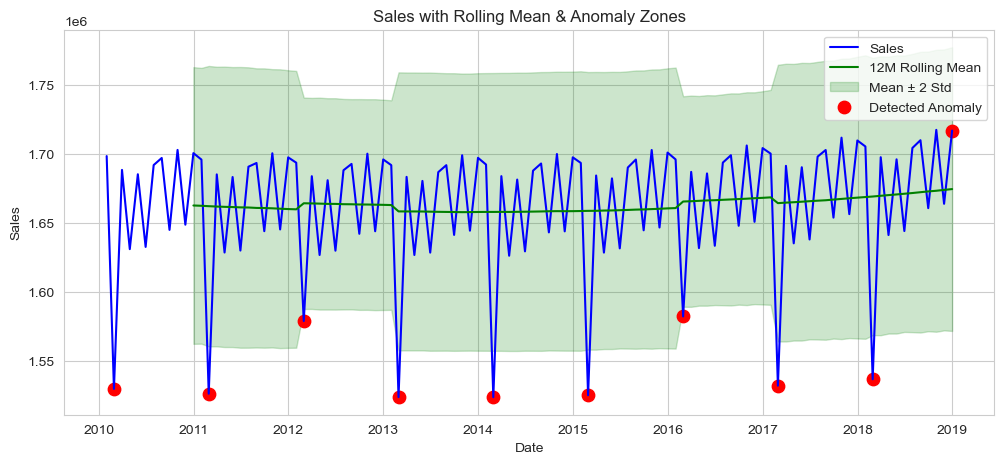

In [179]:
# visualize rolling statistics alongside anomaly bands
plt.figure(figsize=(12,5))
plt.plot(monthly_df['Date'], monthly_df['sales'], label='Sales', color='blue')
plt.plot(monthly_df['Date'], monthly_df['rolling_mean'], color='green', label='12M Rolling Mean')
plt.fill_between(monthly_df['Date'],
monthly_df['rolling_mean'] - 2*monthly_df['rolling_std'],
monthly_df['rolling_mean'] + 2*monthly_df['rolling_std'],
color='green', alpha=0.2, label='Mean ± 2 Std')
plt.scatter(monthly_df.loc[monthly_df['anomaly_combined'],'Date'],
monthly_df.loc[monthly_df['anomaly_combined'],'sales'],
color='red', s=80, label='Detected Anomaly')
plt.title('Sales with Rolling Mean & Anomaly Zones')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
++

# The final visualization overlays anomalies on rolling mean and ±2σ bounds, giving a
# clear and interpretable picture of how each anomaly deviates from typical seasonal
# variability.


In [ ]:
#ENSEMBLE ML MODEL FOR ANOMALY DETECTION

In [189]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

In [195]:
X = df[['number_sold']].values
# Initialize models
models = {
    "IsolationForest": IsolationForest(contamination=0.02, random_state=42),
    "OneClassSVM": OneClassSVM(nu=0.02, kernel='rbf', gamma=0.1),
    "LocalOutlierFactor": LocalOutlierFactor(contamination=0.02, novelty=True),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.02)
}

# Store predictions from each model
predictions = pd.DataFrame(index=df.index)

for name, model in models.items():
    model.fit(X)
    preds = model.predict(X)
    # In sklearn: -1 = anomaly, 1 = normal
    predictions[name] = (preds == -1).astype(int)



In [196]:
df['anomaly_score'] = predictions.sum(axis=1)
df['ensemble_anomaly'] = (df['anomaly_score'] >= 2).astype(int)


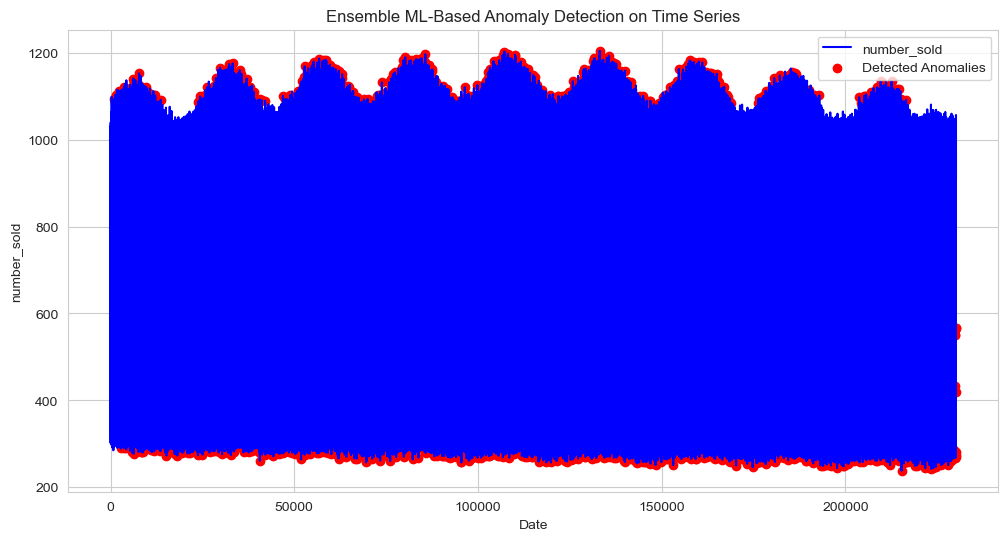

In [201]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['number_sold'], label='number_sold', color='blue')
plt.scatter(
    df.index[df['ensemble_anomaly'] == 1],
    df['number_sold'][df['ensemble_anomaly'] == 1],
    color='red', label='Detected Anomalies', marker='o'
)
plt.title('Ensemble ML-Based Anomaly Detection on Time Series')
plt.xlabel('Date')
plt.ylabel('number_sold')
plt.legend()
plt.show()


In [ ]:
#DON'T CONFUSE BY SEEING NUMBERS AS DATES : in Sklearn while using ensemble dates gets convert to index , 
#for representation i used this format
#Blue region is our normal data points while red one are our anomalies which are detected . 